## **A2 Bias in data**

The project analyze the Wikipedia Talk corpus which is being used to train machine learning models as part of a project called <a id="https://conversationai.github.io/"> Conversation AI</a> by Google data scientists. The purpose of the analysis is to identify what, if any, sources of bias may exist in these datasets, and to develop testable hypotheses about how these biases might impact the behavior of machine learning models trained on the data, when those models are used for research purposes or to power data-driven applications.  
The <a id="https://meta.wikimedia.org/wiki/Research:Detox/Data_Release">Wikipedia talk corpus </a> consists of three datasets. Each dataset contains thousands of online discussion posts made by Wikipedia editors who were discussing how to write and edit Wikipedia articles. Crowdworkers labelled these posts for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy.  
  
We are going to use two of three of the hostile speech: toxicity & aggression for the analysis. The main research questions for this study are:  
* How consistent are labelling behaviours for <b> toxicity</b> hostile speech among workers with different demographic profiles?  
* Are certain words more likely to be associated with comments labelled as hostile speech - toxicity vs aggression?

Both the research questions are intended to find potential bias in data if exists and further discuss the implications of bias found.

### **Table of contents**
1. <a id="test">Step1: Perform analysis on research questions</a>
2. <a id="test">Step2: Potential Implications</a>

In [6]:
import json
import requests
import os
from functools import reduce
from datetime import datetime

import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

## Step1: Perform analysis

#### Load Data
We have manually downloaded the below datasets (3 for each hostile speech) to local drive:  
 
<a id="https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973"> Toxicity Datasets Link</a>: Version 2 posted on 22.02.2017

<a id="https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Aggression/4267550"> Agression Datasets Link</a>: Version 5 posted on 22.02.2017

In [8]:
FOLDER_NAME ='Wikipedia Detox Datasets/'
aggression_annotations =pd.read_csv(FOLDER_NAME + "aggression_annotations.tsv", delimiter="\t")
aggression_worker_demographics =pd.read_csv(FOLDER_NAME + "aggression_worker_demographics.tsv", delimiter="\t")
aggression_annotated_comments =pd.read_csv(FOLDER_NAME + "aggression_annotated_comments.tsv", delimiter="\t")
# remove newline and tab tokens
aggression_annotated_comments['comment'] = aggression_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
aggression_annotated_comments['comment'] = aggression_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
aggression_annotated_comments.reset_index(inplace=True)
aggression_annotations.head(5)

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


In [9]:
aggression_df = pd.merge(aggression_annotations,aggression_worker_demographics, on='worker_id', how='left').fillna("Missing Data")
aggression_df.head(5)

,rev_id,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education
0,37675,1362,1.0,-1.0,male,0,18-30,masters
1,37675,2408,0.0,1.0,male,1,30-45,hs
2,37675,1493,0.0,0.0,female,0,30-45,bachelors
3,37675,1439,0.0,0.0,male,0,18-30,hs
4,37675,170,0.0,0.0,Missing Data,Missing Data,Missing Data,Missing Data


In [10]:
toxicity_annotations =pd.read_csv(FOLDER_NAME + "toxicity_annotations.tsv", delimiter="\t")
toxicity_worker_demographics =pd.read_csv(FOLDER_NAME + "toxicity_worker_demographics.tsv", delimiter="\t")
toxicity_annotated_comments =pd.read_csv(FOLDER_NAME + "toxicity_annotated_comments.tsv", delimiter="\t", index_col = 0)
# remove newline and tab tokens
toxicity_annotated_comments['comment'] = toxicity_annotated_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxicity_annotated_comments['comment'] = toxicity_annotated_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
toxicity_annotated_comments.reset_index(inplace=True)
toxicity_annotations.head(5)

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


Join worker demographic profile with comments data:

In [11]:
toxicity_df = pd.merge(toxicity_annotations,toxicity_worker_demographics, on='worker_id', how='left').fillna("Missing Data")
toxicity_df.head(5)

,rev_id,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education
0,2232.0,723,0,0.0,female,0,30-45,bachelors
1,2232.0,4000,0,0.0,male,1,18-30,hs
2,2232.0,3989,0,1.0,female,0,18-30,bachelors
3,2232.0,3341,0,0.0,Missing Data,Missing Data,Missing Data,Missing Data
4,2232.0,1574,0,1.0,female,0,30-45,bachelors


## Research Question 1: How consistent are labelling behaviours among workers for toxicity hostile speech with different demographic profiles? 
Approach:
1. Identify self selection bias if exist
2. Identify response bias if exist:  
    a. Look at all comments labelled by worker's average toxicity score by different demographic dimensions  
    a. Look at only toxic comments (voted by majority) worker's average toxicity score by different demographic dimensions



### Identify Self Selection Bias (worker's participitation bias):
The First step in identifying the data bias is to understand if <b>Selection bias</b> exist in the data i.e. skewness in the <b>distribution</b> of demographics of workers who assigned labels to the comments. Although, the process of chossing final workers for labeling go through a test to validate the universal understanding of toxicity but it does not make sure if the demographic distribution is balanced. We will analyze and plot the distribution of each demographic dimension available to come to conclusion for selection bias:

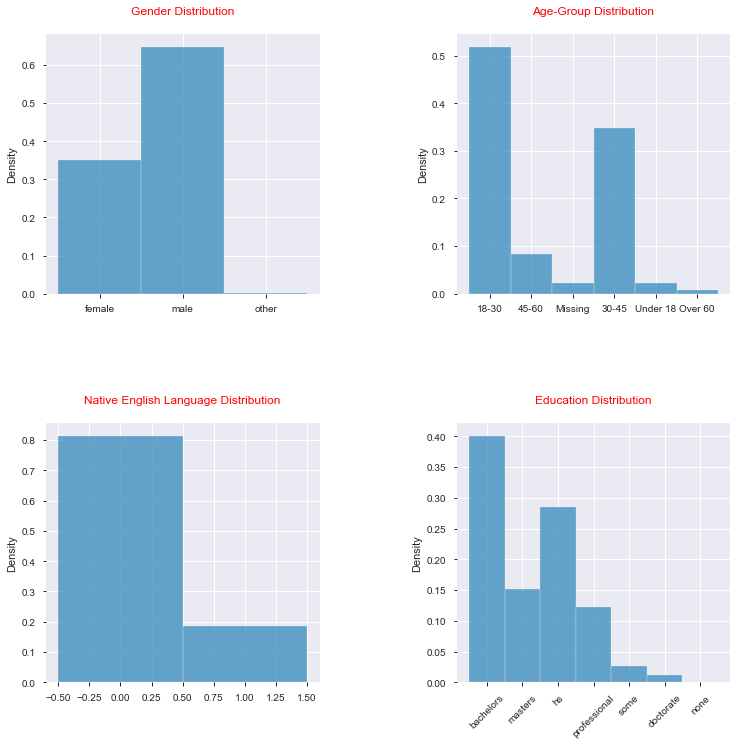

In [389]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.tight_layout()
sns.histplot(toxicity_worker_demographics, x='gender', ax=axs[0][0], stat='density').set_title('Gender Distribution')
sns.histplot(toxicity_worker_demographics, x='english_first_language',             
             ax=axs[1][0], stat='density', discrete=True).set_title('Native English Language Distribution')
sns.histplot(toxicity_worker_demographics.fillna("Missing"), x='age_group',\
             ax=axs[0][1], stat='density').set_title('Age-Group Distribution')
sns.histplot(toxicity_worker_demographics.fillna("Missing"), x='education',  \
              ax=axs[1][1], stat='density').set_title('Education Distribution')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
plt.savefig('Workers participations.png')
for ax in axs.flatten():    
    ax.set_xlabel('')



We can see above that each of the demographic dimension has skewness and may lead to bias in labeling the toxicity. For example: Males are overrepresented & Females are underrepresented, Non-Native English workers are over represented etc.

### Identify Response Bias (worker's bias related to interpretation of toxicity):
We do not know if self selection bias above is adjusted by applying some weighing scheme in the responses or the raw scores are considered. As per the white paper, it is mentioned that final labeling is based on the majority of response. For example - if 6 out of 10 people scores a comment toxic, then it is finally considered toxic. Lets look at the raw distribution of average toxicity score for each worker's demographic dimension to understand response bias:

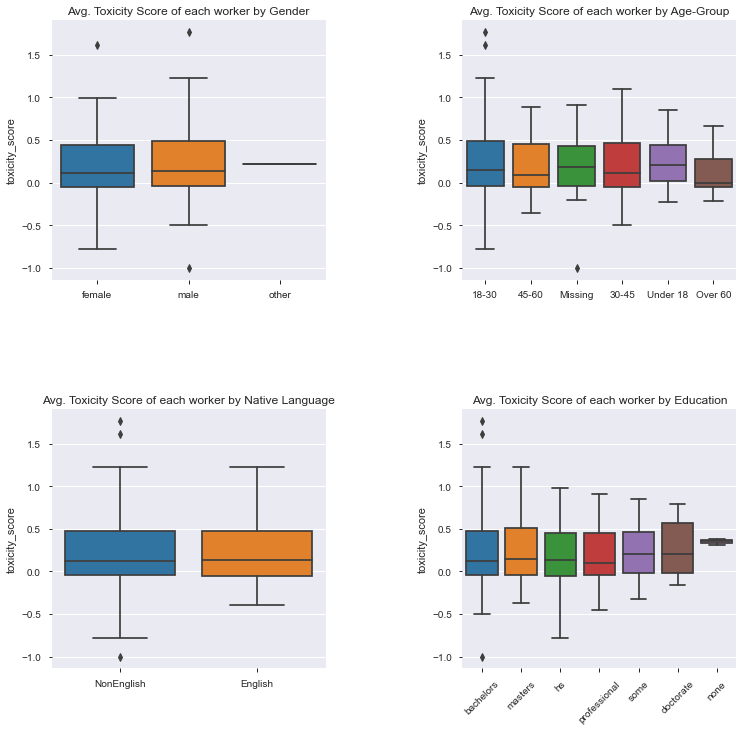

In [220]:
avg_worker_toxicity = toxicity_annotations.groupby("worker_id")["toxicity_score"].mean()
#there are few small number of workers not presented in demographic table which we can ignore by inner join
toxicity_worker_demographics_score = toxicity_worker_demographics.join( avg_worker_toxicity )
toxicity_worker_demographics_score["english_first_language"]=np.where(toxicity_worker_demographics_score.english_first_language==0,"NonEnglish", "English")
toxicity_worker_demographics_score.fillna("Missing", inplace=True)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.tight_layout()
sns.boxplot(data=toxicity_worker_demographics_score, x='gender', \
            y='toxicity_score', ax=axs[0][0]).set_title('Avg. Toxicity Score of each worker by Gender')

sns.boxplot(data=toxicity_worker_demographics_score, x='english_first_language', \
            y='toxicity_score', ax=axs[1][0]).set_title('Avg. Toxicity Score of each worker by Native Language')

sns.boxplot(data=toxicity_worker_demographics_score, x='age_group', \
            y='toxicity_score', ax=axs[0][1]).set_title('Avg. Toxicity Score of each worker by Age-Group')

sns.boxplot(data=toxicity_worker_demographics_score, x='education', \
            y='toxicity_score', ax=axs[1][1]).set_title('Avg. Toxicity Score of each worker by Education')

plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
for ax in axs.flatten():    
    ax.set_xlabel('')
    
plt.savefig('Workers average score of all comments.png')

We can see above that heterogeneity exist with in each group. For example: there are female workers whose average score is close to -1 as shown for the bottom 25% of females in the box-plot line. Similarly, the finding is generalizable to other groups shown above. <b>BUT, THE FINDING IS QUESTIONABLE IF THERE IS ANY SYSTEMATIC ASSIGNMENT IN COMMENTS TO THE WORKERS I.E. IF THE COMMENT IS ONLY LABELED BY PARTICULAR GROUP SUCH AS MALE GROUP. THEREFORE, LET'S LOOK AT THE SIMILAR PLOTS FOR TOP 15k TOXIC COMMENTS WHERE TOXICS COMMENTS ARE DEFINED BY MAJORITY VOTES I.E. AT LEAST 6 WORKERS</b>

Process for finding top 15K toxic comments:  
    1. Verify that all comments are labeled by 10 workers   
    2. FIND all comments where comment's average toxicity is greater than .6  
    3. Plot the average toxicity for each worker as similar to done earlier to see if the plots converge

Text(0, 0.5, 'Number of revids')

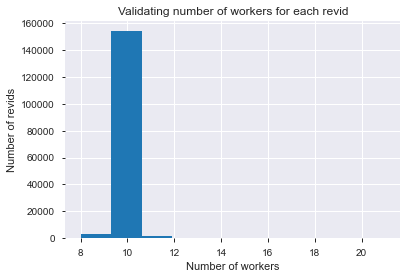

In [221]:
#FIRST VERIFY THAT Most revid are labelled by exactly 10 workers
plt.hist(toxicity_annotations.groupby('rev_id')['worker_id'].count())
plt.title("Validating number of workers for each revid")
plt.xlabel("Number of workers")
plt.ylabel("Number of revids")

TOP X TOXIC WORD COUNT-->  15258


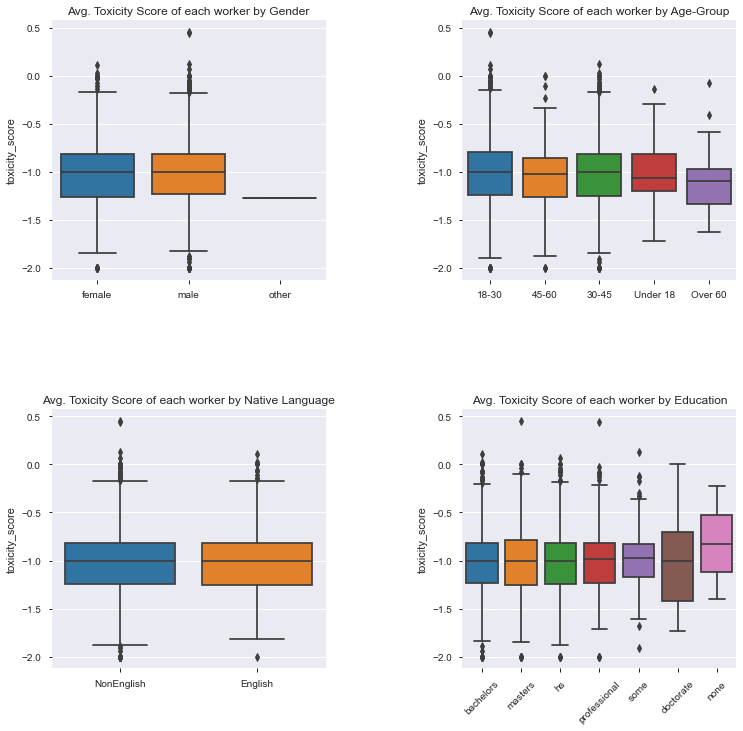

In [216]:
#calculate average of toxicity to find top X words
top_toxic_revid = toxicity_df.groupby("rev_id")["toxicity"].mean().reset_index()
#FILTER NON TOXIC WORDS
top_toxic_revid =top_toxic_revid.loc[top_toxic_revid.toxicity>= .6]

to_simulate_top_toxic_revid = pd.merge(toxicity_df,top_toxic_revid, on='rev_id', how='inner')
to_simulate_top_toxic_revid = to_simulate_top_toxic_revid.groupby("worker_id")["toxicity_score"].mean().reset_index()
toxicity_worker_demographics_score = toxicity_worker_demographics.join( to_simulate_top_toxic_revid,on="worker_id", rsuffix="_r" )

toxicity_worker_demographics_score["english_first_language"]=np.where(toxicity_worker_demographics_score.english_first_language==0,"NonEnglish", "English")

print("TOP X TOXIC WORD COUNT--> ", top_toxic_revid.rev_id.nunique())

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.tight_layout()
sns.boxplot(data=toxicity_worker_demographics_score, x='gender', \
            y='toxicity_score', ax=axs[0][0]).set_title('Avg. Toxicity Score of each worker by Gender')

sns.boxplot(data=toxicity_worker_demographics_score, x='english_first_language', \
            y='toxicity_score', ax=axs[1][0]).set_title('Avg. Toxicity Score of each worker by Native Language')

sns.boxplot(data=toxicity_worker_demographics_score, x='age_group', \
            y='toxicity_score', ax=axs[0][1]).set_title('Avg. Toxicity Score of each worker by Age-Group')

sns.boxplot(data=toxicity_worker_demographics_score, x='education', \
            y='toxicity_score', ax=axs[1][1]).set_title('Avg. Toxicity Score of each worker by Education')

plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1, right=1, top=1, wspace = 0.5, hspace=.5)
for ax in axs.flatten():    
    ax.set_xlabel('')

plt.savefig('Workers average score of top toxic 15k comments.png')

We can see that when looking at only toxic comments, the average score of workers looks much similar. The gender heterogeneity is almost gone when ignoring outliers but we can see some differences in age-group and education.  

Potential Implication: It is seen that self selection bias is not leaking into response bias at this high level of analysis. We cannot find a labeling bias from this analysis.

## Research Question 2: Are certain words more likely to be associated with comments labelled as hostile speech - toxicity or aggression?
Approach:
1. Identify top  comments (by majority vote) that are marked TOXIC but not AGGRESSIVE and vice versa.
2. Conclude if such comments exist that are frequently associated with one type of hostile speech.


### ANALYSIS OF WORDS THAT ARE CONSIDERED TOXIC BUT NOT AGGRESSIVE

Process:
1. Pick top rev_id's belong to toxic comments
2. Filter down the aggressive rev_id' that are toxic
3. Analyze top comments that are toxic but not marked aggressive  
4. Plot word cloud for such sentences

In [16]:
#calculate average of toxicity to find top X words
top_toxic_revid = toxicity_annotations.groupby("rev_id")["toxicity"].mean().reset_index()
top_toxic_revid =top_toxic_revid.loc[top_toxic_revid.toxicity>=.8] #.8 is arbitary to make sure we have enough sample
top_toxic_revid

#find top toxic words that are not aggressive
aggression_annotations_filtered = aggression_annotations.loc[(aggression_annotations.rev_id.isin(list(top_toxic_revid.rev_id.unique())))]
aggressive_revid = aggression_annotations_filtered.groupby("rev_id")["aggression"].mean().reset_index()
aggressive_revid =aggressive_revid.loc[aggressive_revid.aggression<=.3].sort_values('aggression', ascending=True)

comments_toxic = aggression_annotated_comments.loc[aggression_annotated_comments.rev_id.isin(list(aggressive_revid.rev_id))]
pd.set_option('display.max_colwidth', None)
print('Sample TOXIC comments that are not AGGRESSIVE-->')
comments_toxic.loc[~(comments_toxic.comment.str.contains("gay"))][["rev_id", "comment"]].head(10)

Sample TOXIC comments that are not AGGRESSIVE-->


,rev_id,comment
2134,18674888,` maybe you could try and get your message across without all capitals and without swear words (or calling SlimVirgin a jerk and an asshole etc etc). Keeping it civil will give you a slightly better chance of getting your message across. I thought saying ``f**%!ng`` was at least a slight improvement over having all the letters. maybe not. `
2216,18851194,"I don't compare people to Hitler because that is pointless, because no one is like Hitler. You are an evil nazi, but you're not a Hitler-like evil nazi."
2487,19733868,only faggots block people.
4175,27252284,"` ==Vandalism== Thanks for lookin' out for me. Naw, I'm not going to bother saving it. It's not creative enough/bores me. Besides, what the hell is a ``nigger-Jew`` (or whatever he/she called me)? Makes no sense unless I'm Falasha/Beta Israel or something. Hackneyed and stupid. p `"
4317,27909913,"Hey I didn't come up with that Native Australian crap, and how does anti-Australian become racists/ethnocentrists if there's the Anglo-Saxons and there's the various WOGS in Australia, when did Australia become a 'race' or is it a One Nation dream with Anglo-Saxons?"
4917,30652942,dumb dumb dumb........ cool!!!! awsome website for maps is wikipedia
5159,31379050,"As far as I know, shit was an abbreviation used to describe were to store manure in the old shipping days. Stored below deck it was said to become explosive on long voyages. * S.H.I.T. Ship high in transit."
5347,31974214,"Conclusion Dude's a total pimp. I mean, did you see him sitting there in that chair? Exudes pimpocity, I tells ya."
6284,35224726,"` == Blocked by Freestylefrappe == Yeah, that's right, blocked for saying ``IMHO WMC is a jerk.`` Personal insult, huh? Sockpuppet? I'm fucking steamed, Freestylefrappe. And coming right after WMC's admin confirmation? If you're trying to punish me this is some of the most ridiculous bullshit gamesmanship I've ever seen. `"
6352,35474302,I'm trying to start an article on a fairly well-known independent band on the Toronto scene. This is perfectly valid wikipedia material so don't be a jackass and delete it.


Let's find top frequent words from TOXIC comments to understand more why there are not considered aggressive. We can see that words like  'communism', 'hell', 'insult', 'dictator', 'blocked' etc. pops up more frequently.

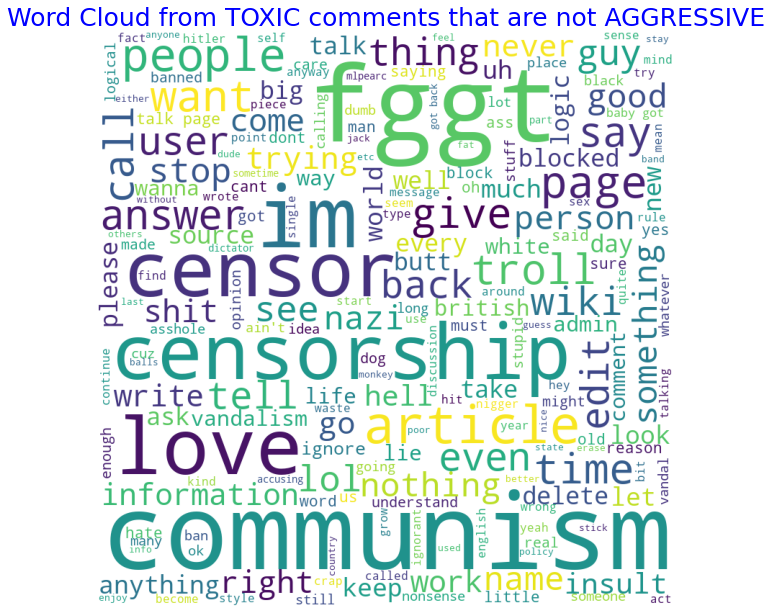

In [18]:
comment_words=''
stopwords = ["really", "know", "now", "will", "one", "wikipedia", "think", "deepak", \
             "valid", "make", "need", "gay"] + list(STOPWORDS) 
  
# iterate through the csv file 
for val in comments_toxic.comment: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Word Cloud from TOXIC comments that are not AGGRESSIVE', fontsize=25, color='blue')

plt.savefig('Word Cloud from TOXIC comments that are not AGGRESSIVE.png')
  
plt.show()

### ANALYSIS OF WORDS THAT ARE CONSIDERED AGGRESSIVE  BUT NOT TOXIC

In [22]:
#calculate average of aggression to find top X words
top_aggression_revid = aggression_annotations.groupby("rev_id")["aggression"].mean().reset_index()
top_aggression_revid =top_aggression_revid.loc[top_aggression_revid.aggression>=.8]


#find top aggressive words that are not toxic
toxicity_annotations_filtered = toxicity_annotations.loc[(toxicity_annotations.rev_id.isin(list(top_aggression_revid.rev_id.unique())))]
toxicity_revid = toxicity_annotations_filtered.groupby("rev_id")["toxicity"].mean().reset_index()
toxicity_revid =toxicity_revid.loc[toxicity_revid.toxicity<=.3].sort_values('toxicity', ascending=True)

comments_aggressive = toxicity_annotated_comments.loc[toxicity_annotated_comments.rev_id.isin(list(toxicity_revid.rev_id))]
pd.set_option('display.max_colwidth', None)
print('Sample AGGRESSIVE  comments that are not TOXIC-->')
comments_aggressive.loc[~(comments_aggressive.comment.str.contains("gay"))][["rev_id", "comment"]].tail(10)

Sample AGGRESSIVE  comments that are not TOXIC-->


,rev_id,comment
151732,649523010.0,"== Your Type-Os == You didnt like my comments on your type? Dont be a cry baby, ok? You breakin mah hard hat."
152289,653235208.0,"I am South African. I am South African. − :That does not make you exempt from WP:NPOV. - + :That does not make you exempt from WP:NPOV. − So: SA President Jacob Zuma spending USD 27 million of taxpayer money (that should be used to vaccinate all children - which they refuse to do!) - this is a fact - not someone´s imagination- is not NPOV? It is encyclopedic and NPOV !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! − Pres. Zuma abused his power to spend USD 27 million to make non-security related - luxurious - improvements to his private proverty - similar to Republican Schock who made a USD 40 000 Red Room make-over to his political head office - at the expense of taxpayers´ money - for which he resigned immediately when exposed on public TV in the USA (are you against that??????????????) − − ALL of this is NPOV: UNLESS YOU ARE CORRUPT, WHICH APPARENTLY YOU ARE VERY MUCH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"
152659,655104717.0,": All I can say is this: 'Dr' K. cannot be trusted. Why? Letme just say this: Best advice I was ever given was given to me by myself: do not trust Trojan Horses or people who try to give one to you. :Greece has demonstrated remarkable 'Trojan-ness' with this veering off to the Chinese and the Russians. This fact is undeniable. Perhaps you yourself are Greek, and resent my exposure of your betrayal of Europa Union."
153311,659906507.0,It's what you do? I thought you stacked shelves at the local supermarket ... alongside the rest of the graduate failures.
153647,662192405.0,Dnon't you dare speak to me this way. I couldn't give a damn if the person i was addressing is respected by you or not. Your opinions mean nothing.
156662,679832272.0,"You were and are hopelessly mistaken about that. Not much point going into it - it's not rocket science. It is an obvious and necessary improvement). You can disagree, but calling it baiting is irrational."
157364,684816096.0,"` ::::Also, as far as BlackCab, again you don't know that HE has ``personally attacked me`` and others, with words such as ``deranged`` and that BlackCab over the months and years has been in LOTS of trouble and notice pages. You're being too hasty and quick without all the facts and knowledge. And singling me out, as if BlackCab and Jezzy are saints or something. Sighs... Far from the truth. (No, seriously, they have been rude and unfair, but for some weird reason you just don't see it anywhere with Jezz...even though he unquestionably violated WP, and has been uncivil and disrespectful and hypocritical...with lies and double standards. He said I did not talk about the article itself (a lie) and only soapboxed him as if he never said anything negative about me in individual comments of his. And he also said that I ignored ``Bold Revert Discuss`` when I have been discussing a great deal. ::::I get your point that I re-inserted earlier on before discussing, but you're acting like not violating 3RR means absolutely nothing. There's a balance, beecause I know that edit-warring can happen even without breaking 3RR, but it's not like I did not put big work and presentations and rationales on the article talk page, taking time and energy. Totally unappreciated by Jezz (and apparently by you). You notice so-called uncivil remarks and behavior from me and nothing from Jezz, which makes me question your analysis to be honest. He's been horrendous and you don't even seem to care or even admit it...or see it! He wrote individual comments soapboxxing against me. That goes un-addressed (accept by me). And then he insanely accuses me of what he was blatantly himself guilty of doing. Unbelievable. `"
157389,684953216.0,"Gilea

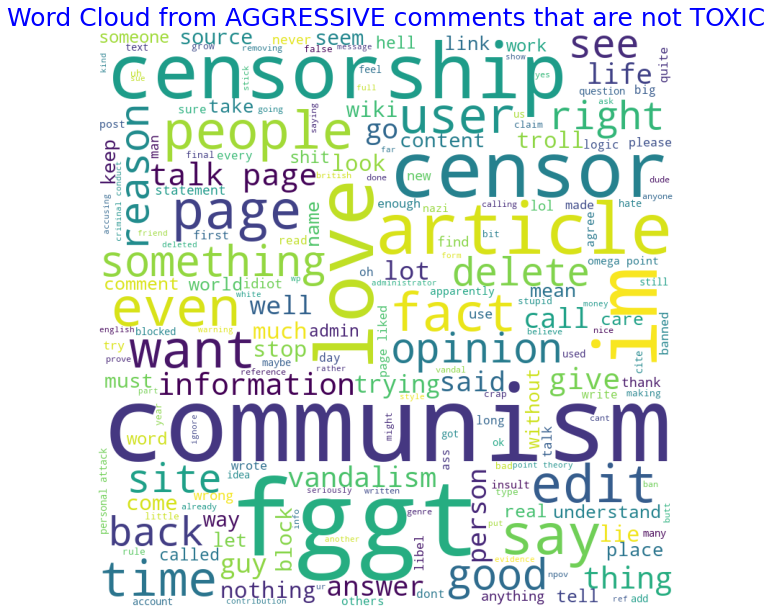

In [21]:
stopwords = ["really", "know", "now", "will", "one", "wikipedia", "think", "deepak", \
             "valid", "make", "need", "gay"] + list(STOPWORDS) 
  
# iterate through the csv file 
for val in comments_aggressive.comment: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Word Cloud from AGGRESSIVE comments that are not TOXIC', fontsize=25, color='blue')

plt.savefig('Word Cloud from AGGRESSIVE comments that are not TOXIC.png')
  
plt.show()

There are lot of common words poppping up between aggressive and toxic comments but interestingly the sentences do not qualfty to be common in both hostile of speech. 

## Step2: Potential Implication  
Let's answer few specific questions on implication of potential bias in trianing data to the demo applications listed in the <a id="https://github.com/conversationai/perspectiveapi/wiki/perspective-hacks"> Perspective Hacks</a>.


#### 1 Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?  

The WikiDetox project is the most suitable application as the model is trained on underlying corpus of wikipedia talk. This is most suitable as the application is built for the same domain of data as it is trained on.


#### 2 Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?  

All other applications except WikiDetox, expects to peform poor due to multiple reasons:  
1. we are making assumption of generalization of training data from Wikipedia corpus to other open social media data which is a super set of it.
2. Training data is labelled by workers from specific domain

#### 3 Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?  


Firstly, account for any racism reported in this article by <a link='https://www.engadget.com/2017-09-01-google-perspective-comment-ranking-system.html'>engadget.com</a>. The accounting for such bias requires manually identifying the demographic bias as model stereotypes the majority class and apply appropriate methodology. The existing process of building Data Science models do not have space for "Human Centered Data Science" and I would include a pre-requisite step to validate biases in the model.
